<a href="https://colab.research.google.com/github/laurakn/undergrad_research_2022/blob/master/Updated_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Turns out my computer rejects the tab spacing you're using, so I had to adjust the spacing in the parts of the code I wanted to run, which will probably make it annoying for you to if you open this. If you're writing this in Colab, maybe try changing the tab from 2 spaces to 4 (pretty sure there is a simple way to do this).

# Define the parameters

In [2]:
# copy file path
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.data'
TEST_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.test'
NAME_DATASET_PATH = '/content/drive/MyDrive/Research/Fairness/code/dataset/adult_income/adult.names'


# define the column name of the dataset, required
column_name = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]


drop_na = True

# Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics

# Load Dataset

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Why are you dropping 'fnlwgt'? 

You don't have to load DataFrame, could use instead pd.DataFame.

Would recommend using map instead of where (as added below). Also make sure to have features called 'group' and 'label'. Then if we want to run everything with a different dataset, we don't need to change any code, just two column names.

Also, have to be careful with the label, since I think one file includes a period after ' >50K' and one doesn't

In [6]:
from pandas.core.frame import DataFrame
def adult_feature_engineering(df:DataFrame):
#     df = df.drop(columns=['fnlwgt']) 


#     # income < 50k is 0, otherwise 1
#     df['sex']=np.where(df['sex']==' Male',1,0)
#     df['income']=np.where(np.logical_or(df['income']==' <=50K', df['income']==' <=50K.'),0,1)
#     obj_df = df.select_dtypes(include=['object'])
    
    # map is a little easier to understand, then it is explicitly clear which variable corresponds to 0, and 1
    df['group'] = df['sex'].map({' Male':1, ' Female':0})
    df['label'] = df['income'].map({' <=50K.':0, ' <=50K':0, ' >50K.':1, ' >50K':1})

    df = df.drop(['sex', 'income'],axis=1)

    return df


Can you add comments to the f_load_data? It's not clear from the naming that it is doing more than just loading data. 

Should be clear what data cleaning is happening

In [7]:
# Effect: Load TRAIN data, Test data from separate FILE PATH, label each column accordingly
#         Combine them to do feature engineering and then output separate training and testing dataset

def f_load_data(TRAIN_DATASET_PATH:str,
                TEST_DATASET_PATH:str,
                drop_na:bool = True,
                column_name:list = None,
                ):
    assert(column_name != None)
    train_dataset = pd.read_csv(TRAIN_DATASET_PATH, index_col=False, header=None,
                              names=column_name)

    test_dataset = pd.read_csv(TEST_DATASET_PATH, index_col=False, header=None,
                             names=column_name, skiprows=1)
  
  

    print(f'shape of train: {train_dataset.shape}')
    print(f'shape of test: {test_dataset.shape}')

    if drop_na == True:
        train_dataset = train_dataset.replace({' ?': np.nan}).dropna()
        test_dataset = test_dataset.replace({' ?': np.nan}).dropna()

    # need ignore_index to recalculate new index
    combined_dataset = pd.concat([train_dataset,test_dataset], ignore_index=True)
    

    # Call Feature Engineering 
    combined_dataset = adult_feature_engineering(combined_dataset)
    
    int_df = combined_dataset.select_dtypes(include=['int'])
    obj_df = combined_dataset.select_dtypes(include=['object'])


    # can do scaling in one go without looping over columns
    int_df = (int_df - int_df.min()) / (int_df.max() - int_df.min())
    
    # object make dummy variables
    encoder = ohe()
    encoder.fit(obj_df)
    ohe_df = pd.DataFrame(encoder.transform(obj_df).toarray())
    
    # join scaled interger data and dummy encoded object data frames
    combined_dataset = int_df.join(ohe_df)
    
    index = train_dataset.shape[0]

    train_dataset = combined_dataset.iloc[:index,:]
    test_dataset = combined_dataset.iloc[index:,:]
    return train_dataset, test_dataset

train_dataset, test_dataset = f_load_data(TRAIN_DATASET_PATH, TEST_DATASET_PATH,  True, column_name)

print(f'shape of train: {train_dataset.shape}')
print(f'shape of test: {test_dataset.shape}')
test_dataset.head()

shape of train: (32561, 15)
shape of test: (16281, 15)
shape of train: (30162, 104)
shape of test: (15060, 104)


age    fnlwgt  education-num  capital-gain  ...   92   93   94   95
30162  0.109589  0.144430       0.400000      0.000000  ...  0.0  1.0  0.0  0.0
30163  0.287671  0.051677       0.533333      0.000000  ...  0.0  1.0  0.0  0.0
30164  0.150685  0.219011       0.733333      0.000000  ...  0.0  1.0  0.0  0.0
30165  0.369863  0.099418       0.600000      0.076881  ...  0.0  1.0  0.0  0.0
30166  0.232877  0.125398       0.333333      0.000000  ...  0.0  1.0  0.0  0.0

[5 rows x 104 columns]

In [8]:
train_dataset.index.is_unique

True

#Model Template

I think the issue you have is that your starting training dataset is the whole training set, then you are adding more rows on top of that, so instead of starting out with 0 data, you starting out with thousands of data points.

In [9]:
class Abernethy_p_sampling(object):
    def __init__(self,
                 p,
                 ):
        self.p = p
    
    def get_group(self,
                  all_violation, 
                  chosen_metric):
        t_random_num = np.random.uniform()
        if t_random_num < self.p:
            return all_violation[chosen_metric][1]
        else:
            return None


In [10]:
train_dataset['group'].unique()

array([1., 0.])

In [13]:
# Template model
from sklearn.linear_model import LogisticRegression
import sklearn

class Shekhar_sampling(object):
    def __init__(
      self,
      classifier,
      initial_set_frac:float = 0.1,
      origin_train_dataset:DataFrame = None,
      origin_test_dataset:DataFrame = None,
      protected_label:str = None,
      ):

        assert(protected_label != None)
        assert(0 < initial_set_frac <=1)
        self.protected_label = protected_label
        self.origin_train_dataset = origin_train_dataset.copy()
        self.origin_test_dataset = origin_test_dataset.copy()
        self.best_classifier = sklearn.base.clone(classifier)
        self.empty_classifier = sklearn.base.clone(classifier)

        self.unique_group_label = origin_train_dataset[protected_label].unique()

        # construct the initial training set and remove them from the original set
        self.trainset = self.origin_train_dataset.sample(frac = initial_set_frac)
        self.origin_train_dataset.drop(index=self.trainset.index, inplace=True)

        # Need to reset index to keep everything in order
        self.origin_train_dataset.reset_index(drop=True, inplace=True)
        self.trainset.reset_index(drop=True, inplace=True)
        #display(self.trainset)
        #display(self.origin_train_dataset)

    def update_ez(self, zt, dvc = 3, delta = 0.05):
        self.ez[zt] = 2*(2*dvc*np.log(2*np.e*self.Nz[zt]/dvc))**(1/2) + 2*np.log(2*
            self.Nz[zt]*np.pi*4/(3*delta))
    
    def update_pi(self):
        total = 0
        for key, val in self.Nz.items():
            total += val
        for key, val in self.pi.items():
            self.pi[key] = self.Nz[key]/total
    
    def update_Ut(self, loss_func, C=1):
        loss = 0

        total = 0
        for key, val in self.pi.items():
            total += self.pi[key]*self.ez[key]

        for key, val in self.Ut.items():
            y_pred = self.c_classifier.predict(self.Dz[key])
            loss = loss_func(y_pred, self.Dz_y[key].to_numpy().reshape(-1))
            self.Ut[key] = loss/len(self.Dz[key]) + self.ez[key] + (2*C/self.pi[key])*total
    
    
    # Make a new class for Shekhar because unlike Abernethy, it needs to modify
    # the test dataset during train time
    
    # Question: sometimes it will show error as y only has 1 unique value
    def train(
        self,
        sampling_algorithm,
        loss_func,
        chosen_metric:str = 'Overall_accuracy',
        quiet_mode:bool = True,
        stop_iter_num:int = 1000,
        m = 2
        ):
        self.scores_list = []
        self.metric_result_list = []
        self.run_out_time = {}
        best_score = -1

        self.Dz = {}
        self.Dz_y = {}
        Dt = pd.DataFrame()
        Dt_y = pd.DataFrame()

        self.Nz = {}
        self.pi = {}
        self.Ut = {}
        self.ez = {}

        y_test = self.origin_test_dataset['label']
        X_test = self.origin_test_dataset.drop('label', axis=1)
        
        for tmp_label in self.unique_group_label:
            self.Nz[tmp_label] = 0
            self.Ut[tmp_label] = 0
            self.ez[tmp_label] = 0
            self.pi[tmp_label] = 0
            self.Dz[tmp_label] = pd.DataFrame()
            self.Dz_y[tmp_label] = pd.DataFrame()


        tmp_label = self.unique_group_label

        for t in range(1, int(stop_iter_num/2)):
            minimum_set_label = min(self.Nz.keys(), key=(lambda k:self.Nz[k]))
            if t <= m:
                zt = tmp_label[t-1]
            # get the key of the minimum and the minimum value
            elif self.Nz[minimum_set_label] < t**(1/2):
                zt = minimum_set_label
            # Sometimes the test Dataset only contains 1 label, making it impossible to fit
            elif len(Dt_y[0].unique()) <= 1:
                i = np.random.randint(0,m)
                
                zt = tmp_label[i]
            else:
                self.update_Ut(loss_func)
                zt = max(self.Ut.keys(), key=(lambda k:self.Ut[k]))

            sample_set = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == zt]
            if len(sample_set) < 2 and self.run_out_time[zt] == -1:
                print(f'Run out of sample for group {zt} at iteration {t}')
                self.run_out_time[zt] = t

            # Sample 2 data points and add them to the training dataset
            if len(sample_set) > 2:
                smp_train = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == zt].sample()
                
                self.origin_train_dataset.drop(index=smp_train.index, inplace=True)
                self.origin_train_dataset.reset_index(drop=True, inplace=True)
                Dt_y = pd.concat([Dt_y, smp_train['label']], ignore_index=True)
                Dt = pd.concat([Dt, smp_train.drop('label', axis=1)], ignore_index=True)
                self.Nz[zt] += 1

                smp_test = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == zt].sample()
                
                self.origin_train_dataset.drop(index=smp_test.index, inplace=True)
                self.origin_train_dataset.reset_index(drop=True, inplace=True)
                self.Dz_y[zt] = pd.concat([self.Dz_y[zt], smp_test['label']], ignore_index=True)
                self.Dz[zt] = pd.concat([self.Dz[zt], smp_test.drop('label', axis=1)], ignore_index=True)
            else:
                pass

            if len(self.origin_train_dataset) < 2:
                print(f'Run out of All sample at {t}')
            
            self.update_ez(zt)
            self.update_pi()

            self.c_classifier = sklearn.base.clone(self.empty_classifier)
            #display(Dt_y)

            ###
            # Train the model and make predictions
            ###
            if len(Dt_y[0].unique()) > 1:
                #display(Dt)
                #print(t)
                self.c_classifier.fit(Dt, Dt_y)

                # get test score and fairness violation
                y_pred = self.c_classifier.predict(X_test)
                c_score = self.c_classifier.score(X_test, y_test)
                self.scores_list.append(c_score)

                metric = Fairness_metric(X_test[self.protected_label], true_label=y_test, predict_label=y_pred)
                #print(X_test[self.protected_label])
                
                metric.process()
                all_violation = metric.calculate_all()
                self.metric_result_list.append(all_violation)

        

        # Question: How to define the best classifier?
        return self.best_classifier, self.scores_list, self.metric_result_list
  
    def predict(
      self,
      ):
      return None
  
    def save(
      self,
      path:str):
      return None
  
    def load(
      self,
      path:str):
      return None

In [ ]:
def loss_func(y_pred, y_true):
    #print(y_true)
    #print(y_pred)
    return np.sum(y_pred != y_true) / len(y_pred)


classifier = LogisticRegression( max_iter = 500)
sampling_algorithm = Abernethy_p_sampling(0.5)
model = Shekhar_sampling(classifier,  0.01, train_dataset, test_dataset, 'group')
len(train_dataset)
best_classifier, scores_list, metric_result_list = model.train(sampling_algorithm, loss_func, quiet_mode = False, chosen_metric='Demographic_Parity', stop_iter_num = 500)
# The number of rows do not add up

In [ ]:
vio_list = []
for dict_i in metric_result_list:
  vio_list.append(abs(dict_i['Equal_Opportunity'][2]))
plt.plot(vio_list)

# Training Process

In [14]:
# Template model
from sklearn.linear_model import LogisticRegression
import sklearn

class Training_General(object):
    def __init__(
      self,
      classifier,
      p:float,
      initial_set_frac:float = 0.1,
      origin_train_dataset:DataFrame = None,
      origin_test_dataset:DataFrame = None,
      protected_label:str = None,
      ):

        assert(protected_label != None)
        assert(0 < p <=1)
        assert(0 < initial_set_frac <=1)
        self.protected_label = protected_label
        self.p = p
        self.origin_train_dataset = origin_train_dataset.copy()
        self.origin_test_dataset = origin_test_dataset.copy()
        self.best_classifier = sklearn.base.clone(classifier)
        self.empty_classifier = sklearn.base.clone(classifier)

        # construct the initial training set and remove them from the original set
        self.trainset = self.origin_train_dataset.sample(frac = initial_set_frac)
        self.origin_train_dataset.drop(index=self.trainset.index, inplace=True)

        # Need to reset index to keep everything in order
        self.origin_train_dataset.reset_index(drop=True, inplace=True)
        self.trainset.reset_index(drop=True, inplace=True)
        #display(self.trainset)
        #display(self.origin_train_dataset)

    # Sampling algorithm needs to be a class like Abernethy_p_sampling 
    def train(
      self,
      sampling_algorithm,
      chosen_metric:str = 'Overall_accuracy',
      quiet_mode:bool = True,
      stop_iter_num:int = 1000,
      ):
        self.scores_list = []
        self.metric_result_list = []
        self.run_out_time = {}
        best_score = -1

        unique_p_label = self.origin_train_dataset[self.protected_label].unique()
        for i in unique_p_label:
            self.run_out_time[i] = -1

        stop_training = False
        train_data = self.trainset.copy()
        y = train_data['label']
        X = train_data.drop('label', axis=1)
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

        # fit the initial model and output the prediction
        c_classifier = sklearn.base.clone(self.empty_classifier)
        c_classifier.fit(X_train, y_train)
        y_pred = c_classifier.predict(X_test)

        # obtain score and fairness violation
        initial_score = c_classifier.score(X_test, y_test)
        best_score = initial_score
        self.scores_list.append(initial_score)
        metric = Fairness_metric(X_test[self.protected_label], true_label=y_test, predict_label=y_pred)
        metric.process()
        all_violation = metric.calculate_all()
        self.metric_result_list.append(all_violation)
        
        label_to_sample = sampling_algorithm.get_group(all_violation, chosen_metric)
        c_vio = all_violation[chosen_metric][2]
        if quiet_mode == False: 
            print(f'Initial Score: {initial_score}, Initial violation: {c_vio}, Initial biased group: {label_to_sample}')

        #display(train_data)
        # sample from biased group
        if label_to_sample == None:
            smp = self.origin_train_dataset.sample()
            self.origin_train_dataset.drop(index=smp.index, inplace=True)
            self.origin_train_dataset.reset_index(drop=True, inplace=True)
            train_data = pd.concat([train_data, smp], ignore_index=True)
        else:
            smp = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == label_to_sample].sample()
            self.origin_train_dataset.drop(index=smp.index, inplace=True)
            self.origin_train_dataset.reset_index(drop=True, inplace=True)
            train_data = pd.concat([train_data, smp], ignore_index=True)
            
        iteration = 1

        

        while stop_training == False:
            y = train_data['label']
            X = train_data.drop('label', axis=1)
            X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)


            self.X_train_backup, self.y_train_backup = X_train, y_train

            # fit the initial model and output the prediction
            c_classifier = sklearn.base.clone(self.empty_classifier)
            
            c_classifier.fit(X_train, y_train)
            y_pred = c_classifier.predict(X_test)

            # obtain score and fairness violation
            c_score = c_classifier.score(X_test, y_test)
            self.scores_list.append(c_score)
            metric = Fairness_metric(X_test[self.protected_label], true_label=y_test, predict_label=y_pred)
            #print(X_test[self.protected_label])
            
            metric.process()
            all_violation = metric.calculate_all()
            self.metric_result_list.append(all_violation)

            label_to_sample = sampling_algorithm.get_group(all_violation, chosen_metric)
            c_vio = all_violation[chosen_metric][2]
            if quiet_mode == False and iteration % 500 == 0: 
                print(f'Score: {c_score}, violation: {c_vio}, biased group: {label_to_sample}')

            #print(all_violation)

            
            if c_score > best_score:
                best_score = c_score
                self.best_classifier = c_classifier

            # sample from biased group
            biased_set = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == label_to_sample]
            if label_to_sample != None and len(biased_set) == 0 and self.run_out_time[label_to_sample] == -1:
                print(f'Run out of sample for group {label_to_sample} at iteration {iteration}')
                self.run_out_time[label_to_sample] = iteration

            if label_to_sample != None and len(biased_set) != 0:
                smp = self.origin_train_dataset[self.origin_train_dataset[self.protected_label] == label_to_sample].sample()
                
                self.origin_train_dataset.drop(index=smp.index, inplace=True)
                self.origin_train_dataset.reset_index(drop=True, inplace=True)
                train_data = pd.concat([train_data, smp], ignore_index=True)
            else:
                smp = self.origin_train_dataset.sample()
                self.origin_train_dataset.drop(index=smp.index, inplace=True)
                self.origin_train_dataset.reset_index(drop=True, inplace=True)
                train_data = pd.concat([train_data, smp], ignore_index=True)

            if len(self.origin_train_dataset) == 0 or iteration >= stop_iter_num:
                stop_training = True
            iteration += 1


        # How to define the best classifier?
        return self.best_classifier, self.scores_list, self.metric_result_list
  
    def predict(
      self,
      ):
      return None
  
    def save(
      self,
      path:str):
      return None
  
    def load(
      self,
      path:str):
      return None

In [ ]:
classifier = LogisticRegression( max_iter = 500)
sampling_algorithm = Abernethy_p_sampling(0.5)
model = Training_General(classifier, 0.7, 0.01, train_dataset, test_dataset, 'group')
len(train_dataset)
best_classifier, scores_list, metric_result_list = model.train(sampling_algorithm, quiet_mode = False, chosen_metric='Demographic_Parity', stop_iter_num = 500)
# The number of rows do not add up

In [ ]:
vio_list = []
for dict_i in metric_result_list:
  vio_list.append(abs(dict_i['Equal_Opportunity'][2]))
plt.plot(vio_list)

# Generate plot

In [29]:
# Generate iteration versus fair dataframe 
def Abernethy_generate_t_vs_fair(
    classifier,
    sampling_algorithm,
    num_trials,
    param_list,
    iter_num,
    chosen_metric,
):
    res = []
    for p in param_list:
        for i in range(num_trials):
            model = Training_General(classifier=classifier, p=p, initial_set_frac=0.001, 
                origin_train_dataset=train_dataset, origin_test_dataset = test_dataset, protected_label='group')
            best_classifier, scores_list, metric_result_list = model.train(sampling_algorithm, quiet_mode = False, chosen_metric=chosen_metric, stop_iter_num = iter_num)
            tmp_dict = metric_result_list[-1]
            res.append([p, abs(tmp_dict['Demographic_Parity'][2]), abs(tmp_dict['Equal_Opportunity'][2]),
                   abs(tmp_dict['Equal_Odds'][2]), abs(tmp_dict['Overall_accuracy'][2])])
    res = pd.DataFrame(res, columns=['p', 'Demographic_Parity', 'Equal_Opportunity', 'Equal_Odds', 'Overall_accuracy'])
    return res

# Generate the error vs fairness violation plot
def Abernethy_generate_plot(
    classifier,
    sampling_algorithm,
    num_trials,
    param_list,
    iter_num,
    chosen_metric,
):
    x_list = []
    y_list = []
    for p in param_list:

        ###
        # Average the score over num_trials models with the same parameter
        ###
        tmp_x_list = []
        tmp_y_list = []
        for i in range(num_trials):
            model = Training_General(classifier=classifier, p=p, initial_set_frac=0.001, 
                origin_train_dataset=train_dataset, origin_test_dataset = test_dataset, protected_label='group')
            best_classifier, scores_list, metric_result_list = model.train(sampling_algorithm, quiet_mode = False, chosen_metric=chosen_metric, stop_iter_num = iter_num)
            tmp_dict = metric_result_list[-1]
            tmp_x_list.append(abs(tmp_dict['Overall_accuracy'][2]))
            tmp_y_list.append(abs(tmp_dict[chosen_metric][2]))
        
        x_list.append(np.average(tmp_x_list))
        y_list.append(np.average(tmp_y_list))
    plt.plot(x_list, y_list)

    #

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.25], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.16666667], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [-0.14285714], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.14285714], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [-0.2], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 1.0, Initial violation: [-0.25], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [-0.16666667], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [-0.2], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [-0.33333333], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 1.0, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [-0.14285714], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [-0.2], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 1.0, Initial violation: [-0.16666667], Initial biased group: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [-0.2], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.4], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.13333333], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [-0.16666667], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.33333333], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [-0.2], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 1.0, Initial violation: [-0.14285714], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.4], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.2], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [-0.16666667], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [-0.42857143], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.75, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.25, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [0.], Initial biased group: 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.875, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.625, Initial violation: [0.], Initial biased group: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

Initial Score: 0.5, Initial violation: [0.], Initial biased group: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

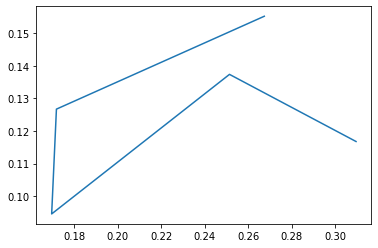

In [31]:
classifier = LogisticRegression( max_iter = 500)
sampling_algorithm = Abernethy_p_sampling(0.5)
df = Abernethy_generate_t_vs_fair(classifier, sampling_algorithm, 10, [0.1, 0.2, 0.5], 100, 'Equal_Opportunity')
df.to_csv('t_vs_fair.csv')

Abernethy_generate_plot(classifier, sampling_algorithm, 10, [0.1, 0.2, 0.3, 0.4, 0.5], 100, 'Equal_Opportunity')

# Test Code

In [ ]:

smp = train_dataset[train_dataset["sex"]== 0].sample()
print(smp)
index = smp.index
print(train_dataset.iloc[index])
#print(smp.index)
train_dataset.drop(index=smp.index, inplace=True)
train_dataset.reset_index(drop=True, inplace=True)
print(train_dataset.iloc[index])

In [ ]:
train_dataset.index.is_unique

# Fairness Metric

In [16]:
import numpy as np
import pandas as pd

In [17]:
#self.true_data = train_dataset[[protected_col,label_col]].to_numpy()
# true_data is |protected_label | true_y |

class Fairness_metric(object):
  def __init__(
      self,
      protected_label:list,
      true_label:list,
      predict_label:list,
      ):
    assert(len(protected_label) == len(true_label))
    assert(len(predict_label) == len(true_label))
    self.protected_label = np.array(protected_label)
    self.predict_label = np.array(predict_label)
    self.true_label = np.array(true_label)
    self.res_mat = {}
    # res_mat: 
    # key : protected label 
    # val: [TP, FP, FN, TN]
    
  def process(self):
    for key in np.unique(self.protected_label):
      self.res_mat[key] = [0,0,0,0]
      # TP, FP, FN, TN
    for i in range(len(self.predict_label)):
      tmp_prot = self.protected_label[i]
      tmp_true = self.true_label[i]
      tmp_pred = self.predict_label[i]
      if tmp_true == tmp_pred and tmp_true == 1:
        # TP
        self.res_mat[tmp_prot][0] +=1
      elif tmp_true == 1 and tmp_pred == 0:
        # FN
        self.res_mat[tmp_prot][2] +=1
      elif tmp_true == 0 and tmp_pred == 1:
        # FP
        self.res_mat[tmp_prot][1] +=1
      elif tmp_true == 0 and tmp_pred == 0:
        # TN
        self.res_mat[tmp_prot][3] +=1
      else:
        print('Incorrect Code')

  # This is for two protected labels, can be adapted to multiple protected labels
  # output an dict of scores of all labels and a list containing biased group with
  # its violation
  def Demographic_Parity(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] = [TP+FP]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation
  
  def Equal_Opportunity(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] =[TP]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation
  
  def Equal_Odds(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] =[TP+FP]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation

  def Overall_accuracy(
      self,
      ):
    res = {}
    # [label : score]
    for label, tmp_list in self.res_mat.items():
      TP = tmp_list[0]
      FP = tmp_list[1]
      FN = tmp_list[2]
      TN = tmp_list[3]
      tot = np.sum(tmp_list)
      res[label] =[TP+FN]/tot

    min_violation = 99
    min_label = None

    for label, score in res.items():
      for label_2, score_2 in res.items():
        if label == label_2:
          pass
        vio = score-score_2
        if vio < min_violation:
          min_violation = vio
          min_label = label
    
    assert(min_violation != 99)
    assert(-1 <= min_violation <= 0)
    assert(min_label != None)
    return res , min_label, min_violation


  # return dict with {metric_name: (score, highest violation label, violation)}
  def calculate_all(self):
    return_dict = {}
    return_dict['Demographic_Parity'] = self.Demographic_Parity()
    return_dict['Equal_Opportunity'] = self.Equal_Opportunity()
    return_dict['Equal_Odds'] = self.Equal_Odds()
    return_dict['Overall_accuracy'] = self.Overall_accuracy()
    return return_dict


In [18]:
protected_label = [0, 1, 0, 1 , 1]
predict_label = [1,0,1,1,0]
true_label = [1, 1, 0, 1, 0 ]

metric = Fairness_metric(protected_label, true_label, predict_label)
metric.process()
#print(metric.Overall_accuracy())
all_data = metric.calculate_all()
c_label = all_data['Overall_accuracy'][2]
print(all_data)

{'Demographic_Parity': ({0: array([1.]), 1: array([0.33333333])}, 1, array([-0.66666667])), 'Equal_Opportunity': ({0: array([0.5]), 1: array([0.33333333])}, 1, array([-0.16666667])), 'Equal_Odds': ({0: array([1.]), 1: array([0.33333333])}, 1, array([-0.66666667])), 'Overall_accuracy': ({0: array([0.5]), 1: array([0.66666667])}, 0, array([-0.16666667]))}
